<a href="https://colab.research.google.com/github/tpgus2603/2024S-Ajou-ML/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

# pytorch 기초

pytorch의 장점은 backword를 자체적으로 수행할 수 있다는 것입니다.

아래의 코드는 2차원 데이터로 2차원의 weight와 1개의 bias 계산하는 예제입니다.

- (requires_grad=True) 가 설정된 tensor들은 자동으로 gradiant를 계산하고 저장합니다.

- loss_function을 통해 구해진 값에 대하여 .backword()를 수행하면 gradiant를 계산하게 됩니다.


In [ ]:
import torch

X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

# Initialize weights and bias with requires_grad=True
w = torch.tensor([[0.0], [0.0]], dtype=torch.float32,requires_grad=True)
b = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)
def forward(X):
    return torch.matmul(X, w) + b

def loss(Y, Y_pred):
    return ((Y_pred - Y) ** 2).mean()

learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    Y_pred = forward(X)
    l = loss(Y, Y_pred)

    # gradiant 초기화
    w.grad = None
    b.grad = None

    # backward pass
    l.backward()

    # weights와 bias 업데이트
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {l.item()}')

print("Trained weights:", w)
print("Trained bias:", b)

Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.182020902633667
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.14805902540683746
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.1290162056684494
Epoch 91, Loss: 0.12043382972478867
Trained weights: tensor([[0.8717],
        [0.8450]], requires_grad=True)
Trained bias: tensor([-0.0267], requires_grad=True)


아래의 예시는 위와 동일한 코드이지만, 편하게 사용할 수 있는 함수들입니다.

- 각 대응되는 부분들을 확인해보세요

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Define the data
X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

initial_weight = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
initial_bias = torch.tensor([0.0], dtype=torch.float32)


LinearModel = nn.Linear(in_features=2, out_features=1, bias=True)  # linear layer
LinearModel.weight.data = initial_weight.clone() #동일한 결과를 위해 동일하게 초기화
LinearModel.bias.data = initial_bias.clone() #동일한 결과를 위해 동일하게 초기화


criterion = nn.MSELoss() # loss fucntion 정의


optimizer = optim.SGD(LinearModel.parameters(), lr=0.01) # optimizer 정의

# Training loop
n_iters = 100
for epoch in range(n_iters):

    Y_pred = LinearModel(X)


    loss = criterion(Y_pred, Y)

    optimizer.zero_grad() # gradiant 초기화
    loss.backward() # backword process
    optimizer.step() # weight (&bias) update

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


trained_weight, trained_bias = LinearModel.weight.data, LinearModel.bias.data
print("Trained weights:", trained_weight)
print("Trained bias:", trained_bias)


Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.18202082812786102
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.1480589509010315
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.12901611626148224
Epoch 91, Loss: 0.12043388187885284
Trained weights: tensor([[0.8717, 0.8450]])
Trained bias: tensor([-0.0267])


#### GPU 사용

- 런타임 > 런타임 유형변경 > GPU 선택
- .to() method를 사용하여 GPU로 모델과 데이터를 올릴 수 있음
- .cuda() 를 사용하는 것도 가능


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LinearModel.to(device) # GPU로 올리기
print(LinearModel)

Linear(in_features=2, out_features=1, bias=True)


In [ ]:
X = X.to(device) # data도 GPU로 올려야 연산 가능함

In [ ]:
LinearModel(X)

tensor([[2.5349],
        [4.2516],
        [5.9683],
        [7.6850]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
LinearModel.cpu() # 다시 CPU로
X.cpu()

# 문제 1


- MNIST Dataset을 활용하여 손글씨 이미지(숫자)를 예측하는 모델을 만드세요.
- 해당 데이터는 0~9까지의 숫자를 가지고 있습니다.

In [ ]:
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split

MNIST 데이터를 데이터 로더에 넣어서 사용하면 미니 배치 단위로 꺼내 쓸 수 있습니다.

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True, # training data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

val_size = 5000
train_size = len(training_data) - val_size
training_data, val_data = random_split(training_data, [train_size, val_size])

# Load test data
test_data = datasets.MNIST(
    root="data",
    train=False, # test data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

# data loader
# train, test 각각의 data loader 생성
smaple_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5116310.39it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134037.47it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1279229.14it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9482592.72it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# train feature와 label을 train_loader로부터 가져오기
sample_features, sample_labels = next(iter(smaple_loader))
print(f"Feature batch shape: {sample_features.size()}")
print(f"Labels batch shape: {sample_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


#### 이미지로 확인

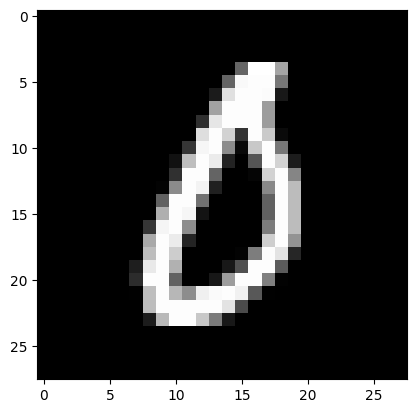

Label: 0


In [ ]:
img = sample_features[0].squeeze()
label = sample_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 문제 1-1

MNIST 데이터셋을 아래의 조건에 따라 학습시키세요.

Fully connected layer (multi layer perceptron)로 NeuralNetwork를 아래의 조건에 맞게 완성하세요.

 - NeuralNetwork 모델 구축
    - 3개의 linear layer와 2개의 ReLU layer를 사용하세요.
    - nn.Linear, nn.ReLU
    - 각 layer의 hidden dimension size는 자유롭게 설정합니다.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  # 28x28 이미지를 784 픽셀 값의 배열로 변경
        self.linear_relu_stack = nn.Sequential(
            # 3개의 linear layer와 2개의 ReLU layer를 구성하세요
            # =================================================== #
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
            # =================================================== #
        )

    def forward(self, x):
        # forward 함수 구현
        # =================================================== #
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        # =================================================== #
        return logits  # forward 결과 저장

## 문제 1-2

위에서 만든 NeuralNetwork 모델을 학습시키세요.
train과 test함수를 만들세요.

- CrossEntropy 사용 (nn.CrossEntropyLoss)
- Epoch : 10, batch size : 32
- validation 정확도 90% 이상

In [ ]:
# hyperparameter 설정
import torch.optim as optim

FcModel = NeuralNetwork()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(FcModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches

# data loader의 batch size을 16로 변경
train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [ ]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        size = len(dataloader.dataset)
        data_, target_ = data_.to(device), target_.to(device)

        # 모델 예측
        pred = model(data_)
        # 손실 계산
        loss = loss_fn(pred, target_)
        optimizer.zero_grad()
        # 역전파를 통해 그래디언트 계산
        loss.backward()

        # 옵티마이저를 통해 파라미터 업데이트
        optimizer.step()
        # 손실 및 정확도 계산
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()

        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

In [ ]:
def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            size = len(dataloader.dataset)
            data_, target_ = data_.to(device), target_.to(device)
            pred = model(data_)

            # 손실 계산
            loss = loss_fn(pred, target_)

            # 정확도 계산
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()

            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [ ]:
FcModel.cuda()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'/'

In [ ]:
best_loss = np.inf
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   FcModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , FcModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "checkpoints/NN_best.pth")


 10%|█         | 1/10 [00:12<01:50, 12.33s/it]

epoch:0     train_loss = 0.2026 , train_acc:0.9422     val_loss = 0.2117 , val_acc:0.9376     learning rate: 0.001


 20%|██        | 2/10 [00:23<01:34, 11.80s/it]

epoch:1     train_loss = 0.1824 , train_acc:0.9485     val_loss = 0.1933 , val_acc:0.9426     learning rate: 0.001


 30%|███       | 3/10 [00:34<01:20, 11.53s/it]

epoch:2     train_loss = 0.1647 , train_acc:0.9534     val_loss = 0.1769 , val_acc:0.9448     learning rate: 0.001


 40%|████      | 4/10 [00:45<01:07, 11.28s/it]

epoch:3     train_loss = 0.1501 , train_acc:0.9578     val_loss = 0.1632 , val_acc:0.9514     learning rate: 0.001


 50%|█████     | 5/10 [00:57<00:56, 11.38s/it]

epoch:4     train_loss = 0.1369 , train_acc:0.9609     val_loss = 0.1545 , val_acc:0.9538     learning rate: 0.001


 60%|██████    | 6/10 [01:08<00:45, 11.37s/it]

epoch:5     train_loss = 0.1253 , train_acc:0.9647     val_loss = 0.1436 , val_acc:0.9550     learning rate: 0.001


 70%|███████   | 7/10 [01:25<00:39, 13.09s/it]

epoch:6     train_loss = 0.1157 , train_acc:0.9673     val_loss = 0.1362 , val_acc:0.9586     learning rate: 0.001


 80%|████████  | 8/10 [01:36<00:25, 12.59s/it]

epoch:7     train_loss = 0.1067 , train_acc:0.9700     val_loss = 0.1252 , val_acc:0.9606     learning rate: 0.001


 90%|█████████ | 9/10 [01:48<00:12, 12.30s/it]

epoch:8     train_loss = 0.0989 , train_acc:0.9725     val_loss = 0.1258 , val_acc:0.9598     learning rate: 0.001


100%|██████████| 10/10 [02:00<00:00, 12.02s/it]

epoch:9     train_loss = 0.0918 , train_acc:0.9743     val_loss = 0.1140 , val_acc:0.9648     learning rate: 0.001


# 문제 1-3 : CNN

- CNN 모델을 아래의 조건과 같이 구축하여 학습하시오.
- validation 정확도 90% 이상

아래의 조건을 만족하는 CNN model을 만드시오.


 - CNN layer 1 - filter 수 32, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 2 - filter 수 64, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 3 - filter 수 128, filter size : 3,
 - Max pooling : 2 x 2
 - Fc layer 1 : last Cnn feature size (flatten) -> 128
 - ReLU ()
 - Fc layer 2 : 128 -> 64
 - ReLU ()
 - Fc layer 3 : 64 -> 10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        #===============================================#
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)


        #===============================================#


    def forward(self, x):

        #===============================================#
        x = self.pool1((self.conv1(x)))
        x = self.pool2((self.conv2(x)))
        x = self.pool3((self.conv3(x)))

        x = x.view(-1, 128 * 3 * 3) # Flatten the tensor

        x = F.relu(self.fc1(x)) #fc layer에만 relu적용
        x = F.relu(self.fc2(x))
        x = self.fc3(x)


        #===============================================#

        return x

In [ ]:
# hyperparameter 설정
import torch.optim as optim
SimModel = SimpleCNN()
SimModel.to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(SimModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches


train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   SimModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , SimModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "checkpoints/Simple_CNN_best.pth")


 10%|█         | 1/10 [00:13<02:05, 13.91s/it]

epoch:0     train_loss = 1.6263 , train_acc:0.4514     val_loss = 0.4189 , val_acc:0.8686     learning rate: 0.001


 20%|██        | 2/10 [00:28<01:54, 14.30s/it]

epoch:1     train_loss = 0.2226 , train_acc:0.9298     val_loss = 0.1410 , val_acc:0.9554     learning rate: 0.001


 30%|███       | 3/10 [00:47<01:54, 16.41s/it]

epoch:2     train_loss = 0.1173 , train_acc:0.9639     val_loss = 0.0901 , val_acc:0.9724     learning rate: 0.001


 40%|████      | 4/10 [01:04<01:39, 16.60s/it]

epoch:3     train_loss = 0.0852 , train_acc:0.9736     val_loss = 0.0811 , val_acc:0.9742     learning rate: 0.001


 50%|█████     | 5/10 [01:17<01:17, 15.45s/it]

epoch:4     train_loss = 0.0690 , train_acc:0.9784     val_loss = 0.0697 , val_acc:0.9764     learning rate: 0.001


 60%|██████    | 6/10 [01:31<00:59, 14.78s/it]

epoch:5     train_loss = 0.0599 , train_acc:0.9815     val_loss = 0.0655 , val_acc:0.9800     learning rate: 0.001


 70%|███████   | 7/10 [01:44<00:43, 14.36s/it]

epoch:6     train_loss = 0.0513 , train_acc:0.9835     val_loss = 0.0556 , val_acc:0.9838     learning rate: 0.001


 80%|████████  | 8/10 [01:58<00:28, 14.05s/it]

epoch:7     train_loss = 0.0465 , train_acc:0.9857     val_loss = 0.0471 , val_acc:0.9862     learning rate: 0.001


 90%|█████████ | 9/10 [02:11<00:13, 13.85s/it]

epoch:8     train_loss = 0.0407 , train_acc:0.9872     val_loss = 0.0462 , val_acc:0.9864     learning rate: 0.001


100%|██████████| 10/10 [02:25<00:00, 14.55s/it]

epoch:9     train_loss = 0.0366 , train_acc:0.9885     val_loss = 0.0528 , val_acc:0.9828     learning rate: 0.001


# Smoke image dataset


- 본 데이터셋은 흡연자의 모습과 비흡자의 모습이 담긴 이미지 파일입니다.
- 이미지 파일을 python으로 가져오기 위해서 다음 과정을 수행합니다.



1.   이미지가 있는 file path를 pandas DataFrame에 label과 함께 저장
2.   데이터 로드를 효율적으로 하기 위해서, 학습 배치마다 해당 path의 이미지를 불러옴



In [4]:
from PIL import Image
from glob import glob

In [5]:
cd ../home

/home


In [6]:
import zipfile
import os

# 압축 해제할 파일 이름
file_name = "qudgks.zip"

# 압축 해제
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
data_path = "/home/qudgks/workspace/smoke"

In [8]:
import pandas as pd
import os
from glob import glob

def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
        file_name = os.path.splitext(img)[0].split("/")[-1]
        if file_name[0:len(label_list[0])] == label_list[0]:
            new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
        elif file_name[0:len(label_list[1])] == label_list[1]:
            new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [9]:
# Example usage:
train_path = data_path + '/Training/Training/'
valid_path = data_path + '/Validation/Validation/'
test_path = data_path + '/Testing/Testing/'
label_list = ['notsmoking', 'smoking']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [10]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 716
val_data:180
test_data:224


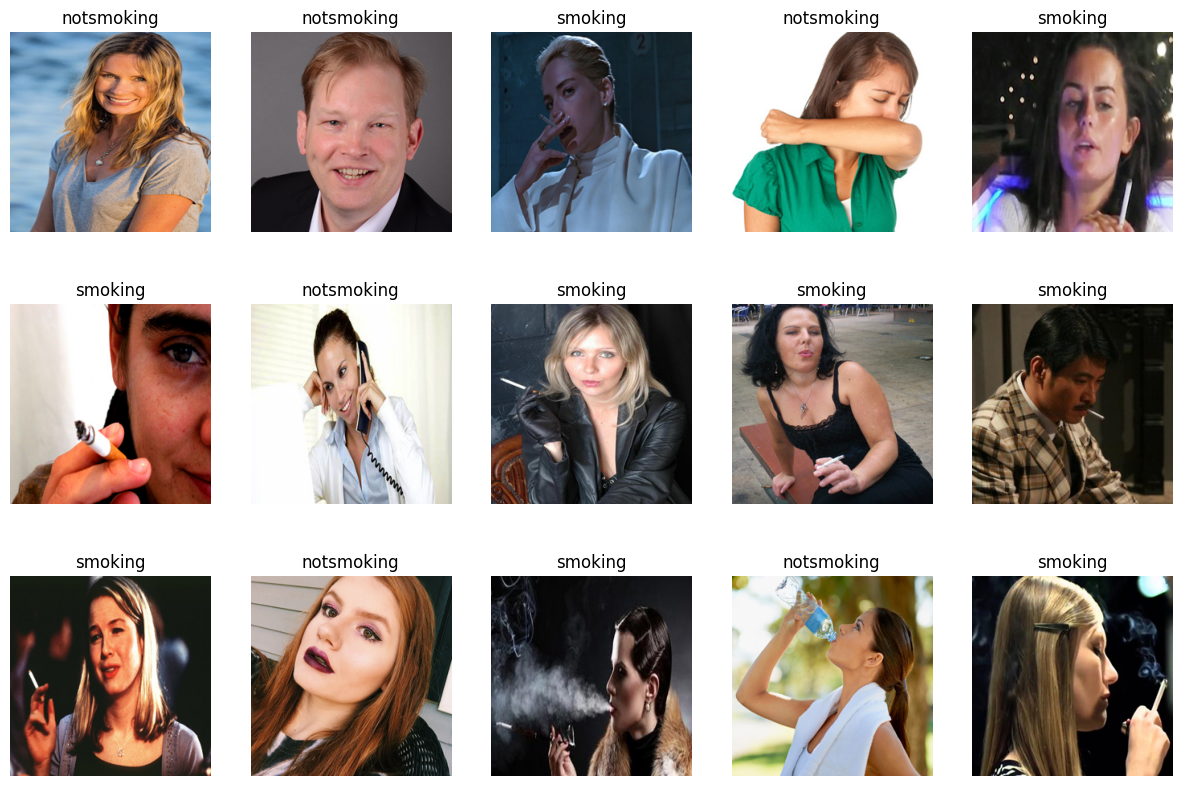

In [11]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Dataset & Dataloader

Pytorch의 Dataset & Dataloader은, 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [12]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [13]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [14]:
SimpleTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]) # dtype 변환

In [15]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
example_dataset = BaseDataset(train_df , SimpleTransforms) # train_transforms
example_loader = DataLoader(example_dataset , batch_size=BATCH_SIZE , shuffle = True)

In [16]:
img, class_id = next(iter(example_dataset))

In [17]:
img.shape # (batch, channel, W, H)

torch.Size([3, 224, 224])

In [18]:
img, class_id = next(iter(example_loader))

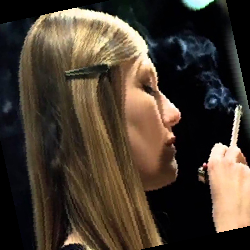

In [19]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


# 문제 2

 1-1의 모델을 **layer를 추가하지 않고**, 아래의 조건을 토대로 성능을
 향상시켜보세요.


 - batch norm, dropout 둘 다 적용
 - data augmentation 기법 1가지 이상 추가
 - layer 자체를 추가하는 것 이외의 다른 방법들 추가 적용 가능
    - kernel size 등등
    - max pooling은 layer로 취급하지 않음
    - 이외 추가적인 hyperparameter 변경 가능
    - feature size 당연히, 수정 가능
 - **test acc (75%) 이상 달성**

In [75]:
CustomTransforms = v2.Compose([
    #==============================#
    v2.RandomHorizontalFlip(), #증강기법 뒤집기
    v2.RandomRotation(10),
    v2.Resize((224, 224)),  # Resize to 224x224
    v2.ToTensor(),  # tensor로 변환
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #nomralize
    v2.RandomResizedCrop(224, scale=(0.8, 1.0)), #임의로 자르기
    #===============================#
    ]) # dtype 변환

In [76]:
#get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()



        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)

        self.fc3 = nn.Linear(128, 1)


        # Define max pooling layer
        self.pool = nn.MaxPool2d(2, stride=2)
        #===============================================#
        #배치 정규화와 드롭아웃정의
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.25)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.5)
        #===============================================#

    def forward(self, x):

        #===============================================#
        #layer마다 배치정규화 ,드롭아웃 적용
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        # Flatten the tensor
        x = x.view(-1, 256 * 28 * 28)


        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout4(x)

        x = F.relu(self.fc2(x))
        x = self.bn5(x)
        x = self.dropout5(x)

        x = self.fc3(x)
        x = torch.sigmoid(x)  # 이진분류를 위해 시그모이드 적용

        #===============================================#

        return x


In [77]:
ImpModel = ImprovedCNN()
ImpModel.to(device)

ImprovedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [96]:

EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
EPOCHS=50
optimizer= optim.Adam(ImpModel.parameters(), lr=0.0007)
Cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
#==============================#

def train(dataloader, model, loss_fn, optimizer, lr_scheduler=None):
    size = 0
    num_batches = len(dataloader)
    model.train()
    epoch_loss, epoch_correct = 0, 0

    for i, (data_, target_) in enumerate(dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        output = model(data_)

        loss = loss_fn(output, target_.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predictions = output.round()
        epoch_correct += (predictions == target_.unsqueeze(1)).type(torch.float).sum().item()
        size += target_.size(0)

    if lr_scheduler is not None:
        lr_scheduler.step()
    return epoch_correct / size, epoch_loss / num_batches

def test(dataloader, model, loss_fn):
    size = 0
    num_batches = len(dataloader)
    epoch_loss, epoch_correct = 0, 0
    with torch.no_grad():
        model.eval()
        for i, (data_, target_) in enumerate(dataloader):
            data_, target_ = data_.to(device), target_.to(device)
            output = model(data_)

            loss = loss_fn(output, target_.float().unsqueeze(1))

            epoch_loss += loss.item()
            predictions = output.round()  # No need to apply sigmoid again
            epoch_correct += (predictions == target_.unsqueeze(1)).type(torch.float).sum().item()
            size += target_.size(0)

    return epoch_correct / size, epoch_loss / num_batches

#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [97]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   ImpModel ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , ImpModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(ImpModel.state_dict() , "checkpoints/Improved_CNN_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , val_loss = test(test_loader , ImpModel , criterion)
        print("Early stop !")
        print(test_acc)
        break

  0%|          | 0/50 [00:00<?, ?it/s]

epoch:0     train_loss = 0.4161 , train_acc:0.8226     val_loss = 0.5407 , val_acc:0.7222     learning rate: 0.0006993093549498951


  2%|▏         | 1/50 [00:11<09:10, 11.23s/it]

epoch:1     train_loss = 0.4226 , train_acc:0.8087     val_loss = 0.5154 , val_acc:0.7500     learning rate: 0.0006972401454600673


  4%|▍         | 2/50 [00:24<09:54, 12.38s/it]

epoch:2     train_loss = 0.4331 , train_acc:0.8017     val_loss = 0.4870 , val_acc:0.7611     learning rate: 0.0006938005377550411


  6%|▌         | 3/50 [00:35<09:16, 11.84s/it]

epoch:3     train_loss = 0.4221 , train_acc:0.7821     val_loss = 0.4672 , val_acc:0.8000     learning rate: 0.0006890041063950208


  8%|▊         | 4/50 [00:46<08:52, 11.59s/it]

epoch:4     train_loss = 0.3970 , train_acc:0.8296     val_loss = 0.4236 , val_acc:0.7722     learning rate: 0.0006828697807033038


 12%|█▏        | 6/50 [01:08<08:02, 10.98s/it]

epoch:5     train_loss = 0.3915 , train_acc:0.8226     val_loss = 0.5526 , val_acc:0.7389     learning rate: 0.0006754217700608879


 14%|█▍        | 7/50 [01:17<07:28, 10.44s/it]

epoch:6     train_loss = 0.3846 , train_acc:0.8408     val_loss = 0.5014 , val_acc:0.7500     learning rate: 0.0006666894683631068


 16%|█▌        | 8/50 [01:26<07:04, 10.11s/it]

epoch:7     train_loss = 0.3678 , train_acc:0.8296     val_loss = 0.5154 , val_acc:0.7611     learning rate: 0.0006567073380153521


 18%|█▊        | 9/50 [01:36<06:48,  9.98s/it]

epoch:8     train_loss = 0.3610 , train_acc:0.8352     val_loss = 0.5201 , val_acc:0.7333     learning rate: 0.0006455147739257052


 20%|██        | 10/50 [01:46<06:35,  9.89s/it]

epoch:9     train_loss = 0.3523 , train_acc:0.8603     val_loss = 0.4606 , val_acc:0.7722     learning rate: 0.0006331559480312316


 22%|██▏       | 11/50 [01:55<06:21,  9.79s/it]

epoch:10     train_loss = 0.3558 , train_acc:0.8310     val_loss = 0.5042 , val_acc:0.7611     learning rate: 0.0006196796349715262


 24%|██▍       | 12/50 [02:05<06:06,  9.65s/it]

epoch:11     train_loss = 0.3341 , train_acc:0.8506     val_loss = 0.5698 , val_acc:0.7000     learning rate: 0.0006051390195974941


 26%|██▌       | 13/50 [02:14<05:56,  9.65s/it]

epoch:12     train_loss = 0.3484 , train_acc:0.8534     val_loss = 0.5021 , val_acc:0.7722     learning rate: 0.0005895914870750411


 28%|██▊       | 14/50 [02:24<05:47,  9.64s/it]

epoch:13     train_loss = 0.3373 , train_acc:0.8506     val_loss = 0.6297 , val_acc:0.7167     learning rate: 0.0005730983964120414
epoch:14     train_loss = 0.3343 , train_acc:0.8464     val_loss = 0.5473 , val_acc:0.7833     learning rate: 0.0005557248383023657


 28%|██▊       | 14/50 [02:35<06:40, 11.13s/it]

Early stop !
0.7678571428571429


# 문제 3: Pretrained model
사전 학습된 모델(Pretrained model)을 통해 위의 이미지 데이터를  흡연 여부를 판별고자 합니다.

이를 위해서 모델을 불러오고, 학습 및 검증하여 최종 성능을 평가하시오.

In [81]:
# pretrained 관련
import torch
import torchvision.transforms as v2
from torchvision import models

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 문제 3-1: Pretrained Model (backborn)모델 학습

아래의 `resnet18` 예제를 참고하여, `vgg16`의 pretrained model를 불러와 Smoke 탐지를 진행할 수 있도록 layer를 수정하시오.

- MyVGG16 Class를 완성하시오.
- Vgg16의 CNN layer들은 모두 frozen하시오.
- 추가적인 layer와 다양한 기법들을 추가해도 됩니다.
- **test acc (75%) 이상 달성**
- **(extra) test acc (80%) 이상 달성시 추가 점수(+1): freeze한 layer fine-tuning 가능**


- https://pytorch.org/vision/stable/models.html 참고

In [83]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [ ]:
print(resnet18) # 각 레이어의 구성을 확인

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [84]:
Last_layer_hiddensize = resnet18.fc.in_features
resnet18.fc = nn.Linear(Last_layer_hiddensize, 1)

In [85]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.6MB/s]


In [ ]:
# nn.Linear(10,10).requires_grad = False # gradiant 끄기
# nn.Linear(10,10).requires_grad = True # gradiant 켜기

In [86]:
import torch.nn as nn
class MyVGG16(nn.Module):
    def __init__(self, pretrained_model):
        super(MyVGG16, self).__init__()
        self.backbone = pretrained_model

        #=============================#
        for param in self.backbone.features.parameters():
            param.requires_grad = False

        # Modify the classifier to suit binary classification
        self.backbone.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 1)
        )
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.extra_layer = nn.Linear(1, 1)  # Define the extra layer
        #=============================#
    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.sigmoid(self.extra_layer(x))
        return x


In [87]:
myvgg16 = MyVGG16(vgg16)

## 문제 3-2: Fine-tuning

- `MyVGG16`를 활용하여 Fine-tuning을 진행하시오.

In [88]:
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
EPOCHS=50
optimizer= optim.Adam(myvgg16.parameters(), lr=0.0005)
Cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
#==============================#


#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [89]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss, epoch_correct = 0, 0
    for i, (data_, target_) in enumerate(dataloader):

        #===================================================#
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        output = model(data_)

        loss = loss_fn(output, target_.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predictions = output.round()
        epoch_correct += (predictions == target_.unsqueeze(1)).type(torch.float).sum().item()
        size += target_.size(0)
        #===================================================#

    train_acc = epoch_correct / size
    lr_scheduler.step()

    return train_acc, epoch_loss / num_batches

def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            data_, target_ = data_.to(device), target_.to(device)
            output = model(data_)

            loss = loss_fn(output, target_.float().unsqueeze(1))

            epoch_loss += loss.item()
            predictions = output.round()  # No need to apply sigmoid again
            epoch_correct += (predictions == target_.unsqueeze(1)).type(torch.float).sum().item()
            size += target_.size(0)
            #========================================#

    test_acc = epoch_correct/size
    return test_acc  , epoch_loss / num_baches

In [90]:
myvgg16.cuda()

MyVGG16(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [91]:
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader,
                                  myvgg16,
                                  criterion,
                                  optimizer,
                                  Cosine_lr_scheduler)

    val_acc, val_loss = test(val_loader, myvgg16, criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f}, train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myvgg16.state_dict(), "checkpoints/myvgg_16_best.pth")
    else:
        counter += 1

    if counter >= patience:
        test_acc, test_loss = test(test_loader, myvgg16, criterion)
        print("Early stop!")
        print(test_acc)
        break


  0%|          | 0/50 [00:00<?, ?it/s]

epoch:0     train_loss = 0.6781, train_acc:0.6131     val_loss = 0.3275, val_acc:0.8667     learning rate: 0.0004995066821070679


  4%|▍         | 2/50 [00:25<09:54, 12.39s/it]

epoch:1     train_loss = 0.5590, train_acc:0.6592     val_loss = 0.4427, val_acc:0.7889     learning rate: 0.0004980286753286195


  6%|▌         | 3/50 [00:35<09:00, 11.50s/it]

epoch:2     train_loss = 0.5391, train_acc:0.6690     val_loss = 0.3326, val_acc:0.8889     learning rate: 0.0004955718126821722
epoch:3     train_loss = 0.4835, train_acc:0.7081     val_loss = 0.2874, val_acc:0.8833     learning rate: 0.0004921457902821578


 10%|█         | 5/50 [00:59<08:36, 11.47s/it]

epoch:4     train_loss = 0.4815, train_acc:0.7165     val_loss = 0.4244, val_acc:0.8556     learning rate: 0.00048776412907378846
epoch:5     train_loss = 0.4657, train_acc:0.6997     val_loss = 0.2654, val_acc:0.9000     learning rate: 0.0004824441214720629


 14%|█▍        | 7/50 [01:22<08:16, 11.55s/it]

epoch:6     train_loss = 0.4526, train_acc:0.7081     val_loss = 0.4737, val_acc:0.7889     learning rate: 0.00047620676311650495


 16%|█▌        | 8/50 [01:33<07:53, 11.27s/it]

epoch:7     train_loss = 0.4361, train_acc:0.7277     val_loss = 0.3284, val_acc:0.8500     learning rate: 0.0004690766700109659
epoch:8     train_loss = 0.4664, train_acc:0.7123     val_loss = 0.2439, val_acc:0.9222     learning rate: 0.00046108198137550377


 20%|██        | 10/50 [01:56<07:37, 11.44s/it]

epoch:9     train_loss = 0.3790, train_acc:0.7612     val_loss = 0.2546, val_acc:0.8944     learning rate: 0.0004522542485937368


 22%|██▏       | 11/50 [02:07<07:17, 11.21s/it]

epoch:10     train_loss = 0.4378, train_acc:0.7193     val_loss = 0.3330, val_acc:0.8500     learning rate: 0.00044262831069394727
epoch:11     train_loss = 0.3964, train_acc:0.7472     val_loss = 0.2431, val_acc:0.8944     learning rate: 0.0004322421568553528


 26%|██▌       | 13/50 [02:33<07:25, 12.03s/it]

epoch:12     train_loss = 0.4430, train_acc:0.7263     val_loss = 0.2588, val_acc:0.8778     learning rate: 0.00042113677648217214
epoch:13     train_loss = 0.4152, train_acc:0.7221     val_loss = 0.2249, val_acc:0.9278     learning rate: 0.0004093559974371724


 30%|███       | 15/50 [02:57<06:51, 11.75s/it]

epoch:14     train_loss = 0.3586, train_acc:0.7709     val_loss = 0.3632, val_acc:0.8778     learning rate: 0.0003969463130731183


 32%|███▏      | 16/50 [03:07<06:23, 11.28s/it]

epoch:15     train_loss = 0.4086, train_acc:0.7346     val_loss = 0.3404, val_acc:0.8722     learning rate: 0.0003839566987447491


 34%|███▍      | 17/50 [03:18<06:05, 11.08s/it]

epoch:16     train_loss = 0.3940, train_acc:0.7430     val_loss = 0.2443, val_acc:0.8944     learning rate: 0.0003704384185254288


 36%|███▌      | 18/50 [03:28<05:50, 10.96s/it]

epoch:17     train_loss = 0.3970, train_acc:0.7207     val_loss = 0.3207, val_acc:0.8833     learning rate: 0.0003564448228912681
epoch:18     train_loss = 0.4008, train_acc:0.7402     val_loss = 0.1932, val_acc:0.9389     learning rate: 0.00034203113817116946


 40%|████      | 20/50 [03:55<06:04, 12.16s/it]

epoch:19     train_loss = 0.3892, train_acc:0.7430     val_loss = 0.2182, val_acc:0.9056     learning rate: 0.00032725424859373676
epoch:20     train_loss = 0.3663, train_acc:0.7486     val_loss = 0.1929, val_acc:0.9167     learning rate: 0.00031217247179121356


 44%|████▍     | 22/50 [04:19<05:32, 11.86s/it]

epoch:21     train_loss = 0.3761, train_acc:0.7304     val_loss = 0.2211, val_acc:0.9222     learning rate: 0.0002968453286464311


 46%|████▌     | 23/50 [04:29<05:09, 11.48s/it]

epoch:22     train_loss = 0.3779, train_acc:0.7472     val_loss = 0.2218, val_acc:0.9278     learning rate: 0.000281333308391076


 48%|████▊     | 24/50 [04:40<04:52, 11.24s/it]

epoch:23     train_loss = 0.3689, train_acc:0.7612     val_loss = 0.2971, val_acc:0.8444     learning rate: 0.0002656976298823283


 50%|█████     | 25/50 [04:51<04:35, 11.01s/it]

epoch:24     train_loss = 0.3461, train_acc:0.7556     val_loss = 0.2675, val_acc:0.9056     learning rate: 0.0002499999999999999


 52%|█████▏    | 26/50 [05:01<04:19, 10.83s/it]

epoch:25     train_loss = 0.3393, train_acc:0.7654     val_loss = 0.3107, val_acc:0.9111     learning rate: 0.00023430237011767157


 54%|█████▍    | 27/50 [05:12<04:07, 10.75s/it]

epoch:26     train_loss = 0.3770, train_acc:0.7430     val_loss = 0.2923, val_acc:0.8722     learning rate: 0.00021866669160892387


 56%|█████▌    | 28/50 [05:22<03:55, 10.70s/it]

epoch:27     train_loss = 0.3615, train_acc:0.7584     val_loss = 0.3926, val_acc:0.8611     learning rate: 0.00020315467135356878


 58%|█████▊    | 29/50 [05:33<03:43, 10.66s/it]

epoch:28     train_loss = 0.3669, train_acc:0.7472     val_loss = 0.2344, val_acc:0.8944     learning rate: 0.00018782752820878623


 60%|██████    | 30/50 [05:43<03:33, 10.67s/it]

epoch:29     train_loss = 0.3779, train_acc:0.7318     val_loss = 0.2047, val_acc:0.9000     learning rate: 0.00017274575140626317
epoch:30     train_loss = 0.3567, train_acc:0.7500     val_loss = 0.2045, val_acc:0.9167     learning rate: 0.00015796886182883053


 60%|██████    | 30/50 [05:56<03:57, 11.89s/it]

Early stop!
0.8883928571428571


# 문제 4: 최종 결과 비교

- 각 BEST 모델을 불러오고 성능 비교 (ImprovedCNN best,VGG16 best)

In [98]:
model_state_dict = torch.load('checkpoints/Improved_CNN_best.pth')
ImpCNN = ImprovedCNN()
ImpCNN.load_state_dict(model_state_dict)

<All keys matched successfully>

In [93]:
model_state_dict = torch.load('checkpoints/myvgg_16_best.pth')
myvgg16 = MyVGG16(vgg16)
myvgg16.load_state_dict(model_state_dict)

<All keys matched successfully>

In [99]:
#=================================#
ImpCNN.to(device)
myvgg16.to(device)
imp_test_acc,_ = test(test_loader, ImpCNN, criterion)
vgg_test_acc,_ = test(test_loader, myvgg16, criterion)

#=================================#
print(f"ImpCNN {imp_test_acc}")
print(f"MyVgg16 {vgg_test_acc}")

ImpCNN 0.78125
MyVgg16 0.9151785714285714
